# Spam Message Detection Project

This notebook demonstrates a complete machine learning pipeline for spam detection in textual messages. 
It walks through data preprocessing, feature extraction using count vectorizer, model training with various algorithms, and evaluation based on standard classification metrics.

The goal is to classify messages as spam or not spam by comparing model performance on a real dataset.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import re
import Functions

In [2]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score,make_scorer,f1_score
from scipy.stats import ks_2samp

In [3]:
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
import warnings

In [ ]:
# Loading the cleaned dataset for spam classification from a CSV file
df = pd.read_csv("/Users/user/Documents/Spam_Detection/Data/new_data_clear.csv")  # Replace with your path

# Dataset description
- The dataset contains preprocessed text messages labeled as spam (1) or non-spam (0).
- Cleaning steps include removing noise, fixing casing, and eliminating irrelevant symbols.
- This step reads the cleaned data to prepare for modeling.

In [ ]:
# Stratified sampling to create a balanced subset for training and testing
N = 4000  # Total number of rows desired

Stratified_Sample = (
    df.groupby('label', group_keys=False)  # Group data by label (spam or not)
    .apply(lambda x: x.sample(int(np.rint(N * len(x) / len(df)))))  # Sample proportionally from each class
    .sample(frac=1)  # Shuffle the rows randomly after sampling
    .reset_index(drop=True)  # Reset index after shuffle
)
df = Stratified_Sample

C:\Users\user\AppData\Local\Temp\ipykernel_12712\775452318.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(int(np.rint(N*len(x)/len(df)))))


# Why stratified sampling?
- To ensure each class (spam or non-spam) is proportionally represented.
- Prevent model bias on imbalanced datasets.
- This improves model generalization and evaluation stability.

In [8]:
df.columns

Index(['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls',
       'date_dt', 'year', 'month', 'day', 'weekday', 'hour', 'is_weekend'],
      dtype='object')

In [ ]:
# Defining feature groups for the model
numerical_features = ['urls']  # Numerical: number of URLs
date_features = ['year', 'month', 'day', 'weekday', 'hour']  # Date and time features
bool_features = ['is_weekend']  # Boolean: whether date is weekend
text_features = ['subject', 'body', 'sender', 'receiver']  # Text fields

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
# Construct column-wise preprocessing including scaling, TF-IDF text encoding, and one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('date', 'passthrough', date_features),  # Date features can be preprocessed individually if more transformations are needed
        ('subject_tfidf', TfidfVectorizer(tokenizer=Functions.spacy_tokenizer), 'subject'),
        ('body_tfidf', TfidfVectorizer(tokenizer=Functions.spacy_tokenizer), 'body'),
        ('sender_tfidf', TfidfVectorizer(tokenizer=Functions.spacy_tokenizer), 'sender'),
        ('receiver_tfidf', TfidfVectorizer(tokenizer=Functions.spacy_tokenizer), 'receiver'),
        ('bool', OneHotEncoder(drop='if_binary'), bool_features)
    ]
)


In [ ]:
# Define features and label columns
X = df[['body', 'sender', 'receiver', 'date', 'subject', 'urls', 'year', 'month', 'day', 'weekday', 'hour', 'is_weekend']]
Y = df['label']  # Target label for spam detection

In [12]:
print(X)

                                                   body  \
0     MY JEWELER COULD NOT TELL \nIT WAS NOT A REAL ...   
1     Your new masculine power will make your belove...   
2     Hi,\n\nwe installed eclipse 3.3.1 on some SLES...   
3     >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...   
4     >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...   
...                                                 ...   
3995  \n\n\n\n\nWomen will do anything for this ice ...   
3996  RMoXGvN\nWeb cam sex perfect ass latina rides ...   
3997  *** ASF Nagios ***\n\nNotification Type: PROBL...   
3998  Dave Mitchell wrote:\n> On Fri, Oct 26, 2007 a...   
3999  >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...   

                                                 sender  \
0        Luxury Designer Replica <david@boothman.co.uk>   
1                           Neal Holt <Neal@allianz.pt>   
2         Frank Steiner <lwvrlirx-chvz0@bio.ifi.lmu.de>   
3            Daily Top 10 <rtilages_1950@relytrans.com>

In [13]:
X.shape

(4000, 12)

In [14]:
X.columns

Index(['body', 'sender', 'receiver', 'date', 'subject', 'urls', 'year',
       'month', 'day', 'weekday', 'hour', 'is_weekend'],
      dtype='object')

In [15]:
Y.shape

(4000,)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Apply full column transformer to the dataset
X = preprocessor.fit_transform(X)


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [17]:
print(X)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 293063 stored elements and shape (4000, 34680)>
  Coords	Values
  (0, 0)	-1.452728435285619
  (0, 1)	2008.0
  (0, 2)	8.0
  (0, 3)	5.0
  (0, 4)	1.0
  (0, 5)	22.0
  (0, 1304)	0.6326554985596797
  (0, 2749)	0.774433354228886
  (0, 6571)	0.32847628929126244
  (0, 15189)	0.2607562460197066
  (0, 15970)	0.5726028552187907
  (0, 22673)	0.326934394455931
  (0, 22998)	0.28643621037917505
  (0, 23440)	0.2949779198770075
  (0, 23943)	0.339637921150303
  (0, 26929)	0.32394102262221536
  (0, 31501)	0.5864179140183688
  (0, 32719)	0.5864179140183688
  (0, 33326)	0.5587737111180964
  (1, 0)	0.6883598996968703
  (1, 1)	2008.0
  (1, 2)	8.0
  (1, 3)	7.0
  (1, 4)	3.0
  (1, 5)	14.0
  :	:
  (3999, 24816)	0.11000948439325996
  (3999, 25300)	0.16439561314023904
  (3999, 25368)	0.08083639567198403
  (3999, 25792)	0.08283744730356599
  (3999, 25895)	0.08367021975610896
  (3999, 25941)	0.07826057139250156
  (3999, 26070)	0.11157775891004953
  (3999, 

In [18]:
X.shape

(4000, 34680)

In [ ]:
# Split the dataset into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [ ]:
# Define the set of models to be trained and evaluated
models = {
    "Logistic Regression": LogisticRegression(),
    # "Naive Bayes": MultinomialNB(),   # Optionally commented out
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "XgBoostclassifier": xgb.XGBClassifier()
}

We selected a mix of classical linear and ensemble models well-suited for text-based binary classification.

In [ ]:
# Train and evaluate all specified models using a custom helper function
Functions.train_model(models, X_train, y_train, X_test, y_test)


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
, Accuracy_Score: 0.97375
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       343
           1       0.96      0.99      0.98       457

    accuracy                           0.97       800
   macro avg       0.98      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800

Confusion Matrix: 
 [[325  18]
 [  3 454]]
Model: Random Forest
, Accuracy_Score: 0.99125
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       343
           1       0.99      1.00      0.99       457

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800

Confusion Matrix: 
 [[338   5]
 [  2 455]]
Model: KNN
, Accuracy_Score: 0.75875
              precision    recall  f1-score   support

           0       0.69      0.79      0.74       343
           1  

## Model Evaluation
Each model is trained and assessed on accuracy, precision, recall, F1-score, and the confusion matrix
to provide detailed comparative insights between algorithms.


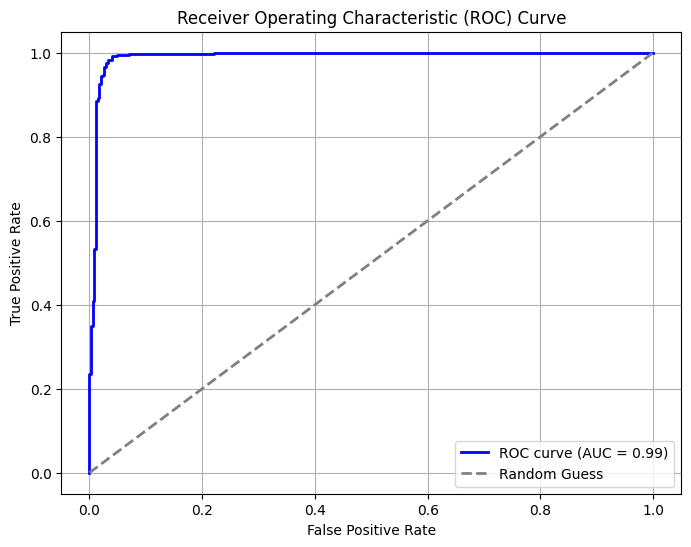

ROC-AUC Score for Logistic Regression: 0.9908


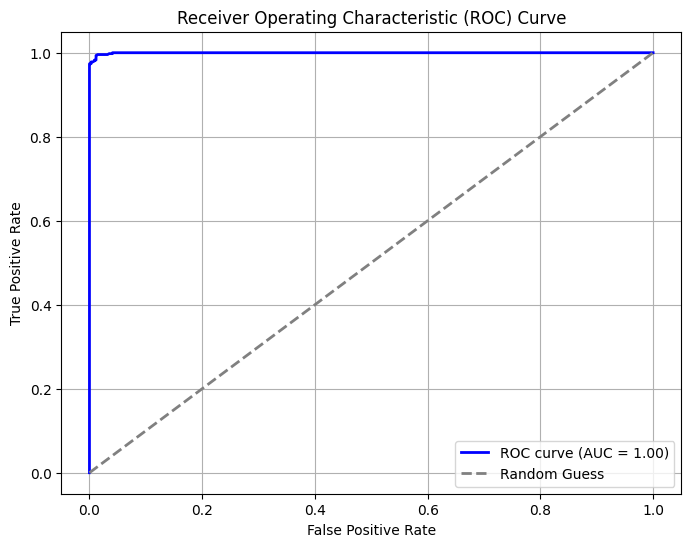

ROC-AUC Score for Random Forest: 0.9996


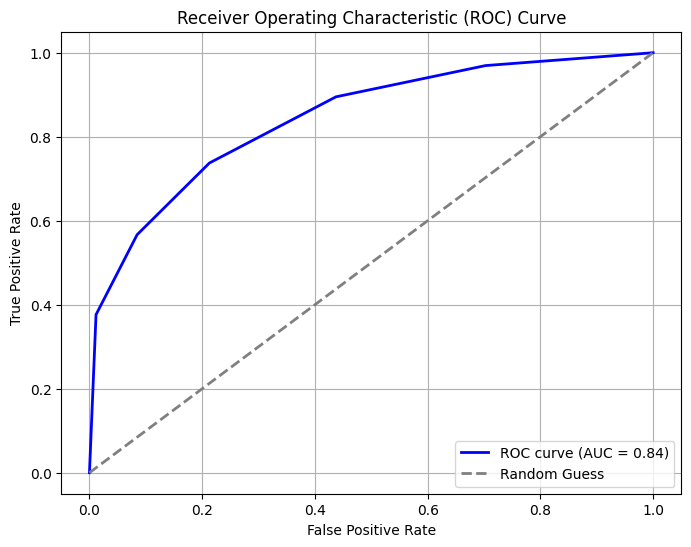

ROC-AUC Score for KNN: 0.8436


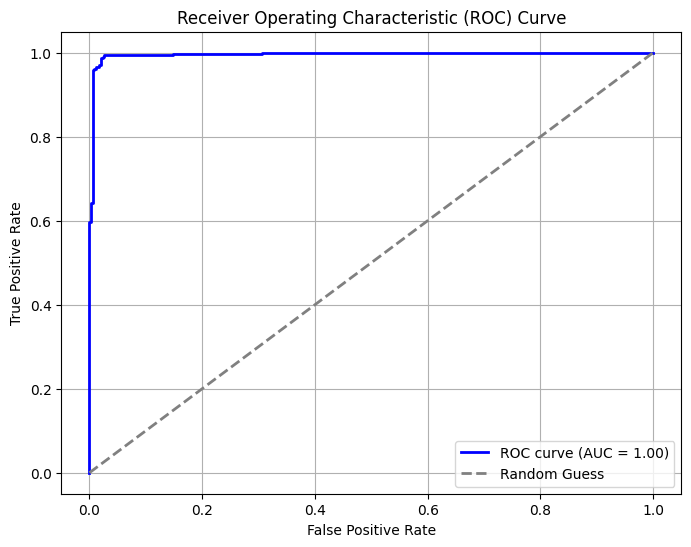

ROC-AUC Score for XgBoostclassifier: 0.9963


In [76]:
Functions.roc_plot(models,X_test, y_test)

### Hyperparameters Optimisation (GridSearch)

In [88]:
scoring = { 'accuracy': make_scorer(accuracy_score), 'recall': make_scorer(recall_score) , 'f1_score':make_scorer(f1_score)} 

In [ ]:
xgb_gridsearch_grid = { "n_estimators": [100, 500, 1000],
                    "learning_rate": [0.1, 0.05, 0.01],
                    "max_depth": [2, 8, 16, 64, 128], 
                    "colsample_bytree": [0.3, 0.8, 1],
                    "gamma": [0,1,5],
                    'reg_alpha': [ 0.01, 0.1, 1],          
                    'reg_lambda': [0.1, 1] } 

knn_gridsearch_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

lr_gridsearch_grid = {
    'penalty': ['l1', 'l2'],
    'C': [100, 50, 10, 1, 0.1, 0.01, 0.001],
    'max_iter': [100,250, 500, 750],
    'solver': ['liblinear', 'saga']
    
    }


rf_gridsearch_grid = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [2, 8, 16, 32, 64, 128],
    'min_samples_split': [2, 4, 8, 16, 24],
    'min_samples_leaf': [1, 2, 5, 10, 15, 30],
}

NB_gridsearch_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0],  
    'fit_prior': [True, False],  
    'force_alpha': [True, False]  
}




In [ ]:
'''models = {
    "Logistic Regression":GridSearchCV(
                        estimator=LogisticRegression(), 
                        param_grid=lr_gridsearch_grid,
                        cv=5, 
                        scoring= scoring,  
                        refit="accuracy",  
                        verbose=0, 
                        n_jobs=-1,
                         ),

    "Naive Bayes":GridSearchCV(
                  estimator=MultinomialNB(),
                  param_grid=NB_gridsearch_grid, 
                  cv=5, 
                  scoring=scoring, 
                  refit='accuracy',
                  verbose=0, 
                  n_jobs=-1),

    "Random Forest":GridSearchCV(
                     estimator=RandomForestClassifier(), 
                     param_grid=rf_gridsearch_grid,
                     cv=5,
                     scoring=scoring,
                     refit='accuracy',
                     verbose=0,
                     n_jobs=-1,
                     ),

    "KNN":GridSearchCV(
            estimator=KNeighborsClassifier(),   
            param_grid=knn_gridsearch_grid, 
            cv=5,  
            scoring=scoring, 
            refit='accuracy', 
            verbose=0,
            n_jobs=-1,  
            ),

    "XgBoostclassifier": GridSearchCV(
                        estimator=xgb.XGBClassifier(), 
                        param_grid=xgb_gridsearch_grid,
                        cv=5,
                        scoring=scoring,
                        refit='accuracy',
                        verbose=0,
                        n_jobs=-1,
                        )} '''

In [ ]:
#Functions.train_model(models,X_train,y_train,X_test,y_test)

# Conclusion

A thorough pipeline, from data cleaning and transformation to supervised classification, shows the superiority of ensemble models such as Random Forest and XGBoost in text-based spam detection.

Next steps may include exploring deep learning methods with word embeddings or transformer-based architectures.
